Сделаем зашрузку данных

(50000, 28, 28) (50000,)


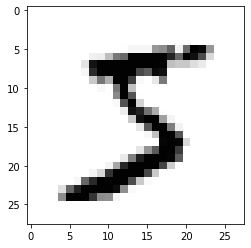

In [1]:
import tensorflow.keras as keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    
    # Оставим 10000 примеров на валидацию
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
## Размеры
print(X_train.shape, y_train.shape)
## Нарисуем пример
plt.imshow(X_train[0], cmap="Greys");

In [2]:
## Сделаем объекты плоскими N*28*28 to  N*784

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)

## Лейблы нужно сделать One-Hot
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train dimension:
(50000, 784)
Test dimension:
(10000, 784)
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


# 1 Переделать модель в Functional API

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

Вот так выглядела модель из предыдущего ноутбука

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(14, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='SGD', 
              metrics=['mean_squared_error'])

Вот так будет в `Functional API`

In [58]:
from keras.models import Model
from keras.layers import Input, Dense

def model_by_functional_api(inp_dim, output_dim, optimizer='adam'):
    input1 = Input(shape=(inp_dim,))
    hidden1 = Dense(14, activation='relu')(input1)
    hidden2 = Dense(12, activation='relu')(hidden1)
    output = Dense(output_dim, activation='softmax')(hidden2)
    model = Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = model_by_functional_api(X_train.shape[1], y_train.shape[1])

# 2 Добавить логирование в Tensorboard, early stopping callback
## 2.1 Callback

In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='callbacks',
        save_freq='epoch')
]
_ = model.fit(X_train, y_train, epochs=7, batch_size=10, 
              validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/7
4969/5000 [============================>.] - ETA: 0s - loss: 0.4356 - accuracy: 0.8715WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: callbacks\assets
5000/5000 [==============================] - 6s 1ms/step - loss: 0.4348 - accuracy: 0.8718 - val_loss: 0.2616 - val_accuracy: 0.9247
Epoch 2/7
5000/5000 [==============================] - 6s 1ms/step - loss: 0.2624 - accuracy: 0.9239 - val_loss: 0.2343 - val_accuracy: 0.9296
Epoch 3/7
5000/5000 [==============================] - 6s 1ms/step - loss: 0.2191 - accuracy: 0.9372 - val_loss: 0.1991 - val_accuracy: 0.9420
Epoch 4/7
5000/5000 [=====

И можно загрузить сохранённую модельку модельку

In [13]:
model = tf.keras.models.load_model('callbacks')

## 2.1 Tensorboard

In [15]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=7, batch_size=10, 
              validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/7
   1/5000 [..............................] - ETA: 4s - loss: 0.0125 - accuracy: 1.0000WARNING:tensorflow:From c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1551 - accuracy: 0.9531 - val_loss: 0.1757 - val_accuracy: 0.9498
Epoch 2/7
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1497 - accuracy: 0.9563 - val_loss: 0.1827 - val_accuracy: 0.9469
Epoch 3/7
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1464 - accuracy: 0.9574 - val_loss: 0.1843 - val_accuracy: 0.9469
Epoch 4/7
5000/5000 [==============================] - 6s 1ms/step - loss: 0.1417 - accuracy: 0.9571 - val_loss: 0.1802 - val_accuracy: 0.9496
Epoch 5/7
5000/5000 [=============

In [17]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6624), started 0:00:36 ago. (Use '!kill 6624' to kill it.)

Красиво, только сразу не запустилось, нужно было прерывать ядро и зановов запускать

`plotly` на максималках

## 3 early stopping
Кароче когда абсолютное значение метрики меняется не сильно заканчиваем учиться

In [75]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.02)
history = model.fit(X_train, y_train, epochs=100, batch_size=10, 
              validation_data=(X_test, y_test), callbacks=[callback_es])

Epoch 1/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.5746 - accuracy: 0.8524 - val_loss: 0.5330 - val_accuracy: 0.8693
Epoch 2/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.5494 - accuracy: 0.8576 - val_loss: 0.5111 - val_accuracy: 0.8729
Epoch 3/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.5293 - accuracy: 0.8622 - val_loss: 0.4937 - val_accuracy: 0.8762
Epoch 4/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.5128 - accuracy: 0.8655 - val_loss: 0.4792 - val_accuracy: 0.8783


# 3 Протестировать: 
- Adagrad, Adam
- Добавление BatchNorm/Dropout

## Adagrad, Adam

In [59]:
model = model_by_functional_api(X_train.shape[1], y_train.shape[1], optimizer='adagrad')

In [60]:
log_dir = "logs_adagrad/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=7, batch_size=10, 
              validation_data=(X_test, y_test), callbacks=[tensorboard_callback], verbose=0)

In [61]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6624), started 0:51:25 ago. (Use '!kill 6624' to kill it.)

Та по большому счёту одинаково

## BatchNorm/Dropout

In [25]:
def model_by_functional_api_drop_bathc(inp_dim, output_dim, optimizer='adam', dropout=0.1, batch_norm=True):
    input1 = Input(shape=(inp_dim,))
    hidden1 = Dense(14, activation='relu')(input1)
    hidden1 = tf.keras.layers.Dropout(dropout, input_shape=(14,))(hidden1)
    if batch_norm:
        hidden1 = tf.keras.layers.BatchNormalization()(hidden1)
    hidden2 = Dense(12, activation='relu')(hidden1)
    hidden2 = tf.keras.layers.Dropout(dropout, input_shape=(12,))(hidden2)
    if batch_norm:
        hidden2 = tf.keras.layers.BatchNormalization()(hidden2)
    output = Dense(output_dim, activation='softmax')(hidden2)
    model = Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = model_by_functional_api(X_train.shape[1], y_train.shape[1])

По warning можн осчитать сколько прошло итераций, ммм новый tf.2

In [41]:
hists = []
d_outs = np.linspace(0.01, 0.2, 5)
for do in d_outs:
    model = model_by_functional_api_drop_bathc(X_train.shape[1], y_train.shape[1], dropout=do)
    h = model.fit(X_train, y_train, epochs=17, batch_size=10, validation_data=(X_test, y_test),
                callbacks=[tensorboard_callback], verbose=0)
    hists.append(h)

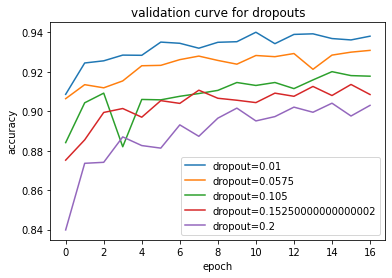

In [42]:
import matplotlib.pyplot as plt

for i, do in enumerate(d_outs):
    plt.plot(hists[i].history['val_accuracy'], label=f'dropout={do}')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('validation curve for dropouts')
plt.legend()
plt.show()

Та не нужем мне этот ваш как его там, дропаут

Так стоп а keras tuner может красивше подбирать гиперпараметры? Посмотрим

In [54]:
import kerastuner

Опять переписывать создание модели, теперь для гиперпараметров(

In [55]:
X_train.shape[1], y_train.shape[1]

(784, 10)

In [62]:
def model_by_functional_api_drop_bathc(hp, inp_dim=784, output_dim=10, optimizer='adam', dropout=0.1, batch_norm=True):
    
    hidden_dim_1 = hp.Int('units', min_value=16, max_value=512, step=32)
    hidden_dim_2 = hp.Int('units', min_value=16, max_value=512, step=32)
    dropout = hp.Choice('deopout', values=[0.5e-1, 1e-1, 2e-1, 3e-1])
    batch_n = hp.Choice('bathc_norm', values=[True, False])
    
    input1 = Input(shape=(inp_dim,))
    hidden1 = Dense(units=hidden_dim_1,
                    activation='relu')(input1)
    hidden1 = tf.keras.layers.Dropout(dropout, input_shape=(hidden_dim_1,))(hidden1)
    if batch_n:
        hidden1 = tf.keras.layers.BatchNormalization()(hidden1)
    hidden2 = Dense(hidden_dim_2, activation='relu')(hidden1)
    hidden2 = tf.keras.layers.Dropout(dropout, input_shape=(hidden_dim_2,))(hidden2)
    if batch_n:
        hidden2 = tf.keras.layers.BatchNormalization()(hidden2)
    output = Dense(output_dim, activation='softmax')(hidden2)
    model = Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [73]:
tuner = kerastuner.tuners.Hyperband(
  model_by_functional_api_drop_bathc,
  objective='val_accuracy',
  max_epochs=30,
  executions_per_trial=5,
  directory='my_dir')

INFO:tensorflow:Reloading Oracle from existing project my_dir\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\untitled_project\tuner0.json


Поставлю ячейку и пойду поем

In [74]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test))

Trial 14 Complete [00h 03m 30s]
val_accuracy: 0.982039999961853

Best val_accuracy So Far: 0.9835400104522705
Total elapsed time: 00h 40m 45s
INFO:tensorflow:Oracle triggered exit
